# Problem statement

### Equation problem

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_{inf}}{T_{b} - T_{inf}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_{inf})}$


- $\epsilon_G=\epsilon(T_b-T_{inf})$


- $\epsilon_C=\beta(T_b-T_{inf})$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$

# Import libraries 

In [1]:
import torch
import imageio
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time

## Device and random seed

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")
random_seed = 1234
torch.manual_seed(random_seed)

Device used: cuda


## Load Data

In [3]:
## Load dataset
relative_csv_path = "./../src/data/raw/heat_transfer_finn.csv"
split_ratio = 0.2

# Load different temperatures samples 
fields_T = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
fields_G = ['G']
fields = fields_T + fields_G
df = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
df_train, df_test = train_test_split(df, test_size = split_ratio, random_state=random_seed)

# Convert into numpy arrays
X_train, Y_train = (df_train[fields_T].to_numpy(), df_train[fields_G].to_numpy())
X_test, Y_test = (df_test[fields_T].to_numpy(), df_test[fields_G].to_numpy())

# Print shapes
print("X_test information:")
print("the size of X_test is", X_test.size)
print("the shape of X_test is", X_test.shape)

print("X_train information:")
print("the size of X_train is", X_train.size)
print("the shape of X_train is", X_train.shape)

print("Y_train information:")
print("the size of Y_train is", Y_train.size)
print("the shape of Y_train is", Y_train.shape)

print("Y_test information:")
print("the size of Y_test is", Y_test.size)
print("the shape of Y_test is", Y_test.shape)

X_test information:
the size of X_test is 900
the shape of X_test is (100, 9)
X_train information:
the size of X_train is 3600
the shape of X_train is (400, 9)
Y_train information:
the size of Y_train is 400
the shape of Y_train is (400, 1)
Y_test information:
the size of Y_test is 100
the shape of Y_test is (100, 1)


## Plot Data 

In [130]:
def plot_data_vs_G(X_train, Y_train, fig_name, num_sample_plots = 15, label_size = 14, marker_size = 5):
    """
    Function to plot some temperature vs G .

    Parameters:
      X_train (ndarray):      Xtrain data set.
      Y_train (ndarray):      Y_train data set.
      fig_name (string):      figure name.
      num_sample_plots (int): number of samples to plot.
      label_size(int):        xtics and legend label size.
      marker_size(int):       xticks and legend marker size.
    """        

    ## Make a subplot with 2 figures
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    # Plot the first figure [thteta1, ..., theta9] vs G
    aux_ones = np.ones((X_train.shape[1],))
    samples_plotted = []

    while len(samples_plotted) <= num_sample_plots:
        sample_picked = np.random.randint(0, X_train.shape[0])
        if sample_picked not in samples_plotted:
            G_sample = Y_train[sample_picked]
            Y_plot = G_sample * aux_ones
            label = 'G = %.2f' %  Y_train[sample_picked]
            ax[0].scatter(X_train[sample_picked,:], Y_plot, label = label, s = marker_size + 2)
            samples_plotted.append(sample_picked)

        if X_train.mean() <=10:
            ax[0].set_xlabel(r'$[\theta_1,... \theta_9]$', fontsize = 1.8*label_size)
        else:
            ax[0].set_xlabel(r'$[T_1,... T_9]$', fontsize = 1.8*label_size)
            
        ax[0].set_ylabel(r'$G$', fontsize = 1.8*label_size)
        ax[0].tick_params(axis='both', which='major', labelsize=label_size)
        ax[0].legend(fontsize = .6*label_size)
        ax[0].grid(True, which="both", ls="-")


    # Plot the second figure theta vs x
    samples_plotted = []

    for i in range(num_sample_plots):
        sample_picked = np.random.randint(0, X_train.shape[1]) 
        if sample_picked not in samples_plotted:
            label = 'G = %.2f' %  Y_train[sample_picked]
            # create a range with interval and number of points 
            aux_x = np.linspace(0, 1, X_train.shape[1])
            ax[1].plot(aux_x, X_train[sample_picked,:],label=label)

    ax[1].set_ylabel(r'$\theta$', fontsize = 1.8*label_size)
    ax[1].set_xlabel(r'$x*$', fontsize = 1.8*label_size)
    ax[1].tick_params(axis='both', which='major', labelsize=label_size)
    ax[1].legend(fontsize = .6*label_size)
    ax[1].grid(True, which="both", ls="-")


    # Save and show thefigure
    fig.savefig(fig_name, bbox_inches='tight')
    plt.show()

### Normalization $\overline{\theta[i,j]} = 2\frac{\theta[i,j] \min(\theta[:,j]) }{\max(\theta[:,j]) - \min(\theta[:,j]) } - 1$ functions:

In [5]:
def normalize_ij(xi, xmin, xmax):
    "Function to normalize a value xi given xmax and xmin boundaries"
    return 2 * (xi - xmin) / (xmax - xmin) - 1

def normalize(X_array, min_X_cols, max_X_cols):
    """
    Normalize an array by columns given a max and min of each column.
    
    Parameters:
    X_array(numpy array): Array to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_array.shape
    normalized_X_array = np.zeros_like(X_array)
    
    # Fill the copy vector
    for col in range(num_col_X): 
      for row in range(num_row_X):
        normalized_X_array[row,col] = normalize_ij(X_array[row,col], min_X_cols[col], max_X_cols[col])
        
    return normalized_X_array

def max_min_by_columns(X_array):
    # Compute the min max vector
    (num_row_X, num_col_X) = X_array.shape
    min_col_X = [np.min(X_array[:,col_X]) for col_X in range(num_col_X)]
    max_col_X = [np.max(X_array[:,col_X]) for col_X in range(num_col_X)]
    return min_col_X, max_col_X 

### Plot $T(x)$ and $[T_1, ..., T_9]$ for different $G$ values

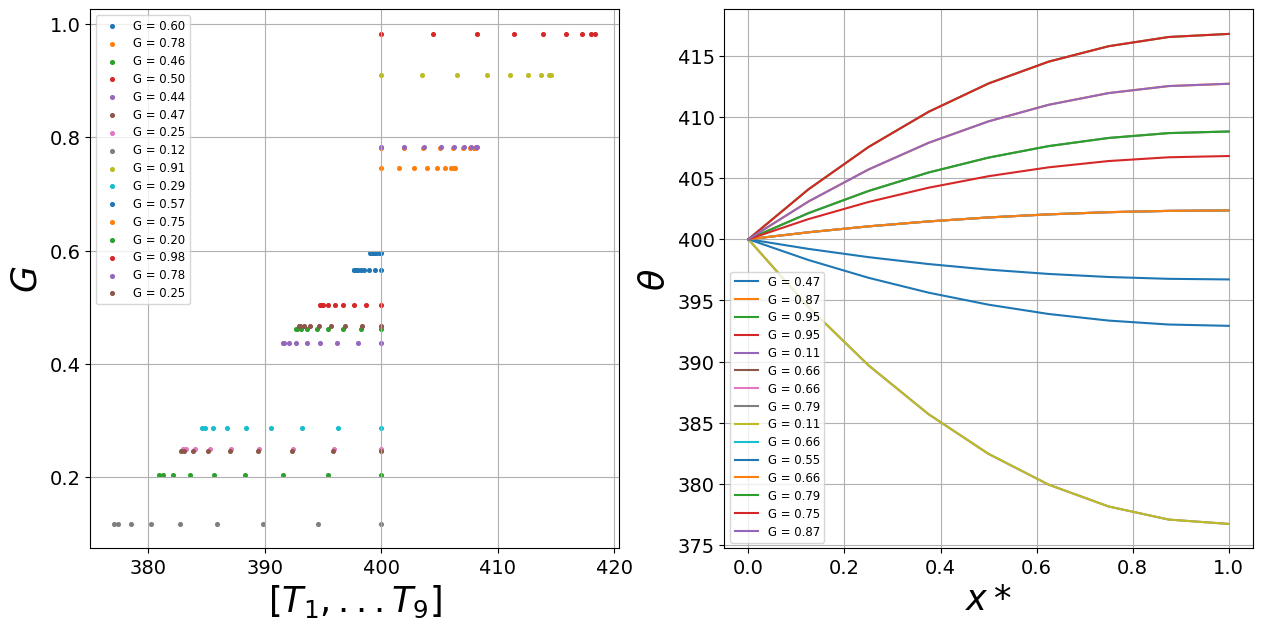

In [131]:
plot_data_vs_G(X_train, Y_train, './part1_outputs/figures/T_vs_G.png') 

## Compute $\theta$ as: `X_train`

In [108]:
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
Theta_train = np.multiply(np.add(X_train, [-T_inf]), [1/(T_b - T_inf)])
Theta_test = np.multiply(np.add(X_test, [-T_inf]), [1/(T_b - T_inf)])

# compute the min max vector
min_theta, max_theta = max_min_by_columns(Theta_train)

## G vs $[\theta_1, \theta_2,... \theta_9]$ and $\theta(x)$

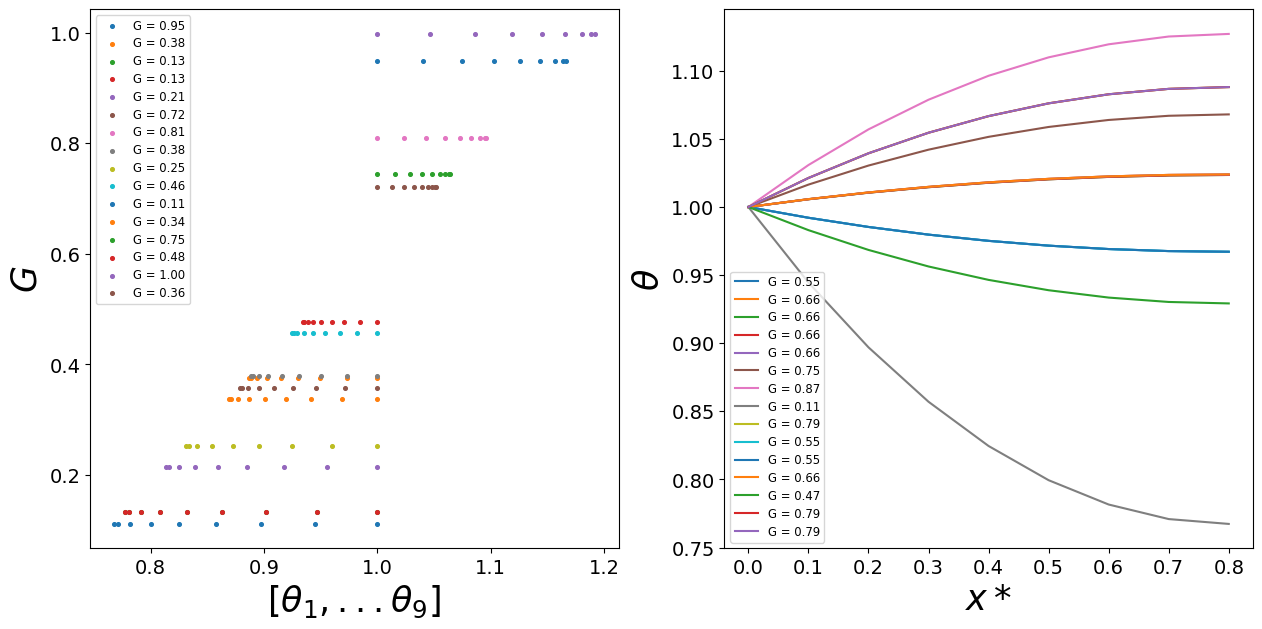

In [104]:
plot_data_vs_G(Theta_train, Y_train, './part1_outputs/figures/Theta_vs_G.png')

## Plot nromalized and reduced $\theta(x)$ for different G values 

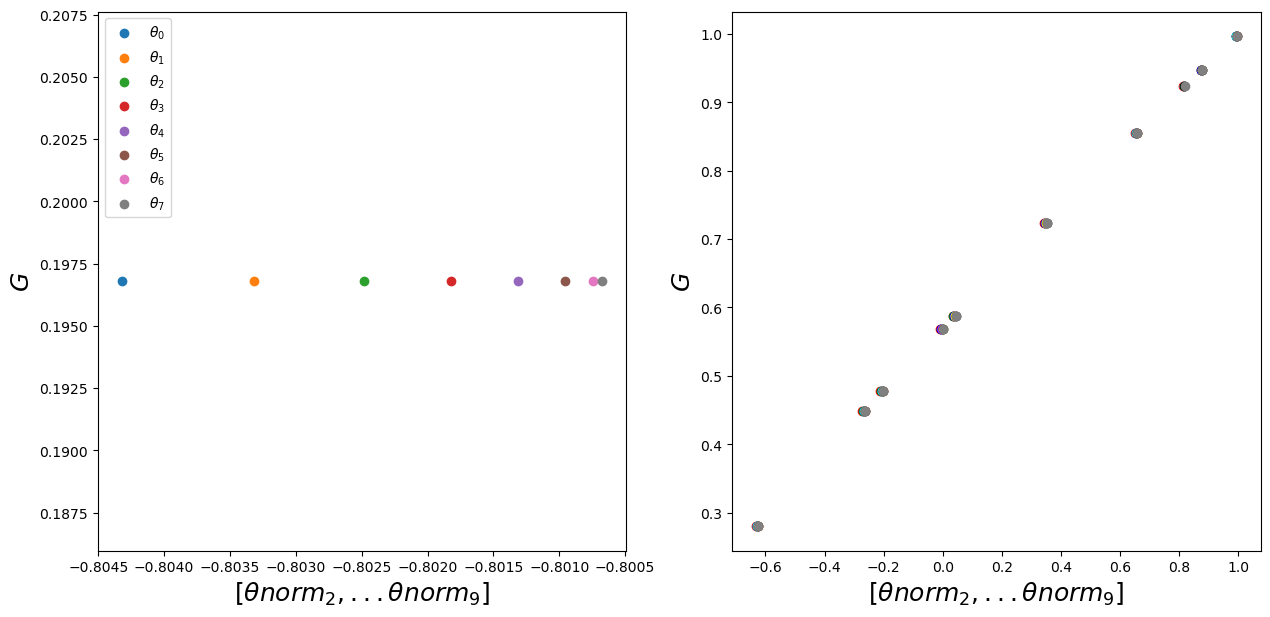

In [9]:
# Normalize and reduce theta 
theta_train_reduced = Theta_train[:,1:]
min_theta_reduced, max_theta_reduced = max_min_by_columns(theta_train_reduced)
theta_train_reduced_normalized = normalize(theta_train_reduced, min_theta_reduced, max_theta_reduced)

## Make a subplot with 2 figures
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Plot parameters
num_sample_plots = 10
label_size = 10

## Plot one random sample of Theta vs G

picked = np.random.randint(0,400,1)
ax[0].cla()
for col in range(theta_train_reduced_normalized.shape[1]):
    aux_ones = np.ones((theta_train_reduced_normalized.shape[0],))
    label = r"$\theta_{}$".format(col)
    ax[0].scatter(theta_train_reduced_normalized[picked, col], Y_train[picked], label = label)   

ax[0].set_xlabel(r'$[\theta norm_2,... \theta norm_9]$', fontsize = 1.8*label_size)
ax[0].set_ylabel(r'$G$', fontsize = 1.8*label_size)
ax[0].tick_params(axis='both', which='major', labelsize=label_size)
ax[0].legend(loc='upper left', fontsize = 10)

aux_ones = np.ones((theta_train_reduced_normalized.shape[1],))
picked = np.random.randint(0,400,num_sample_plots)


col_colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'gray']
for col in range(theta_train_reduced_normalized.shape[1]):
    for it in range(num_sample_plots):
        x = theta_train_reduced_normalized[picked[it], col] 
        y = Y_train[picked[it]]
        ax[1].scatter(x, y, color = col_colors[col])

ax[1].set_xlabel(r'$[\theta norm_2,... \theta norm_9]$', fontsize = 1.8*label_size)
ax[1].set_ylabel(r'$G$', fontsize = 1.8*label_size)
ax[1].tick_params(axis='both', which='major', labelsize=label_size)


### Creates a customizable architecture NN

In [10]:
def create_NN(dim_input, dim_output, nun_nuerons_hidden_layers, num_hidden_layers):
    """
    Function to create a sequentual NN model.

    Parameters:
       dim_input (int):                      Input dimension (number of features).
       dim_output (int):                     Output dimension (number of features).
       num_hidden_layers(int):               Number of hidden layers.
       nun_nuerons_hidden_layers (int):      Number of hidden layers.   
   """      
    # create an empty sequentail model
    Net = torch.nn.Sequential()

    # Add first layer 
    Net.add_module("input_layer", torch.nn.Linear(dim_input, nun_nuerons_hidden_layers))
     
    # Add hidden layers
    for nhidden_layer in range(num_hidden_layers):
        Net.add_module(
            "hidden_layer_num_{}".format(nhidden_layer + 1),
            torch.nn.Linear(nun_nuerons_hidden_layers, nun_nuerons_hidden_layers)
        )
        Net.add_module("hidden_activation_num_{}".format(nhidden_layer + 1 ), torch.nn.LeakyReLU())

    # Add output layer
    Net.add_module("output_layer", torch.nn.Linear(nun_nuerons_hidden_layers, dim_output))
        
    return Net

## Train and test function: ` train_test_model `

In [11]:
def train_test_model(
    num_data_training, 
    nun_nuerons_hidden_layers, 
    num_hidden_layers,
    num_epochs, learining_rate,
    X_train, Y_train, X_test, Y_test,
    min_X_train_reduced, max_X_train_reduced,
    device,
    generate_gif = False,
    normalize_bool = True):
    """
    Function to build, test and train the model.

    Parameters:
       num_data_trainging (int):        Number of samples.
       nun_nuerons_hidden_layers (int): Number of neurons for each hidden layer.
       num_hidden_layers (int):         Number of hidden layers.
       num_epochs (int):                Number of epochs to train the model.   
       learining_rate (float):          Learning rate for the optimizer.    
       X_train (ndarray):               Numpy array contaning the traning set inputs.   
       Y_train (ndarray):               Numpy array contaning the training set outputs.   
       X_test (ndarray):                Numpy array contaning the testing set inputs.   
       Y_test (ndarray):                Numpy array contaning the testing set outputs. 
       max_X_train_reduced(ndarray)     Numpy array contaning the maximum value for each theta column.
       min_X_train_reduced(ndarray)     Numpy array contaning the minimum value for each theta column.
       device (string):                 'cpu' or 'cuda'
       generate_gif (bool):             Boolean to generate a training .gif.
       nromalize_bool (bool):           Boolean to normalize the input data.

   """        
    
    ###############################################
    ############# PROCESS DATA   ##################
    ###############################################
    # Pick the first num data trainig samples for X and Y
    X_train_reduced = X_train[:num_data_training,1:] # Skip the first value since no adds any extra info
    Y_train_reduced = Y_train[:num_data_training]
    num_col_Xr = X_train_reduced.shape[1]
    num_col_Y = Y_train_reduced.shape[1]
    
    # Normalize X_train
    if normalize_bool:
        normalized_X_reduced_train = normalize(X_train_reduced, min_X_train_reduced, max_X_train_reduced)
    else:
        normalized_X_reduced_train = X_train_reduced

    
    # Transofrm from numpy to torch into torch x_train and y_train 
    x_to_plot = normalized_X_reduced_train.reshape(-1,num_col_Xr)             
    x_train = torch.from_numpy(x_to_plot).float().to(device)
    y_train = torch.from_numpy(Y_train_reduced.reshape(-1,num_col_Y)).float().to(device)
    
    ###############################################
    #############   BUILD MODEL  ##################
    ###############################################      
    dim_input = x_train.shape[1]
    dim_output = num_col_Y
    Net = create_NN(dim_input, dim_output, nun_nuerons_hidden_layers, num_hidden_layers)
    Net.to(device)
    
    ###############################################
    #####    TRAIN AND TEST THE  MODEL  ###########
    ###############################################
    
    # Watch x,y variables into torch
    x_train = Variable(x_train)
    y_train = Variable(y_train)
    
    # Select loss and optimizer
    loss_function = torch.nn.MSELoss(reduction ='mean')
    optimizer_adam = torch.optim.Adam(Net.parameters(), lr = learining_rate)
    
    # Define two vectors to store train and test loss
    loss_train = np.zeros(num_epochs)
    loss_test = np.zeros_like(loss_train)
    
    # initilize list to plot gif
    if generate_gif:
        fig, ax = plt.subplots(figsize=(15,10))
        image_list = []

    # init variable to measure time
    start_time = time.time()
    
    # Train and test the model for different epochs
    for epoch in range(num_epochs):
        
        ###############################################
        ############# TESTING STAGE ##################
        ###############################################
        y_nn_train = Net(x_train)
        loss = loss_function(y_nn_train, y_train)  # Notice the order: NN Pred first and then actual value
        optimizer_adam.zero_grad()       # Zero Out the gradient
        loss.backward()
        optimizer_adam.step()
        loss_train[epoch] = loss.to('cpu').detach().numpy()
        
        
        ###############################################
        ############# TESTING STAGE ##################
        ###############################################
        # Normalize X_test
        X_test_reduced = X_test[:,1:] # Skip the first temperature
        if normalize_bool:
            normalized_X_test = normalize(X_test_reduced, min_X_train_reduced, max_X_train_reduced)
        else:
            normalized_X_test = X_test_reduced

        # Convert into torch x_test and y_test 
        x_test = torch.from_numpy(normalized_X_test.reshape(-1,num_col_Xr)).float().to(device)
        y_test = torch.from_numpy(Y_test.reshape(-1,num_col_Y)).float().to(device)

        # Compute y predict and loss function
        y_nn_test = Net(x_test)
        loss_test[epoch] = loss_function(y_nn_test, y_test).to('cpu').detach().numpy()  # Notice the order: NN Pred first and then actual value
        
        # Print gif with 100 images
        if epoch%(num_epochs // 100 )==0 and generate_gif:
        
            # Temperature index to plot 
            temp_to_plot_idx = 0 #[ 0 => T1, 1 => T2]
            x_test_to_plot = normalized_X_test[:,temp_to_plot_idx].reshape(-1,1)
            y_test = (Y_test.reshape(-1,num_col_Y))
            
            # Compute training values to plot 
            x_train_to_plot = x_train.to('cpu').detach().numpy()
            x_train_to_plot = x_train_to_plot[:,temp_to_plot_idx].reshape(-1,1)
            y_train_to_plot = y_train.to('cpu').detach().numpy()
            
            # Compute NN predicted values to plot
            y_nn_to_plot = y_nn_train.to('cpu').detach().numpy()
            
            # Plot
            plt.cla()
            ax.scatter(x_test_to_plot, y_test, color = "red", label="Testing Data")
            ax.scatter(x_train_to_plot, y_train_to_plot, color = "blue", label="Training Data")
            ax.plot(x_train_to_plot[:,0], y_nn_to_plot, 'k--', lw=2,  label="NN Apprximated")
            
            # Labels
            if normalize_bool:
                ax.set_xlabel(r'$norm\theta_{}$'.format(temp_to_plot_idx + 2), fontsize=32)
            else:
                ax.set_xlabel(r'$\theta_{}$'.format(temp_to_plot_idx + 2), fontsize=32)
                
            ax.set_ylabel('$G$', fontsize=32)
            ax.set_xlim(min(x_test_to_plot), max(x_test_to_plot))
            ax.set_ylim(0, 1)
            ax.text(min(x_test_to_plot), 1 , 'Adam Optimizer: epoch = %d,' %epoch, fontdict={'size': 22, 'color':  'black'})
            ax.text(min(x_test_to_plot) + (max(x_test_to_plot) - min(x_test_to_plot))/2, 1, 'Loss = %.6f' % loss,
                    fontdict={'size': 22, 'color':  'black'})
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.legend()
            fig.canvas.draw()      
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            image_list.append(image)


    # Consumed time
    elapsed_time = time.time() - start_time

    # Save gif
    if generate_gif:
        name = './part1_outputs/gifs/Adam_ndata_{}_nhlayers_{}_nromalized_{}.gif'.format(num_data_training, num_hidden_layers, normalize_bool)
        imageio.mimsave(name, image_list, fps=5)
    
    print(f"With num_data_training: {num_data_training} the final loss is: {loss:.5e}")
    
    return loss_test, loss_train, elapsed_time

## Train the model for different number of  $\theta$ data training

In [19]:
# model hyper-params
num_epochs = 3000
num_of_neurons = 32
num_of_hidden_layers = 2
lr = 1e-4

# range for number of data training
nun_data_training = range(10,401,10)

In [20]:
# Paramters to select
normalization_bool = True
plot_gif_bool = False

# result arrays to be filled
testing_error = np.zeros(len(nun_data_training))
elapsed_time_cpu = np.zeros_like(testing_error)
loss_test = np.zeros((len(nun_data_training),num_epochs))
loss_train = np.zeros_like(loss_test)


# GPU execution
device = 'cuda'
elapsed_time_gpu = np.zeros_like(testing_error)

print("Training with : " + device)
for i,num_data in enumerate(nun_data_training):
    loss_train[i,:], loss_test[i,:], elapsed_time_gpu[i]= train_test_model(
        num_data, num_of_neurons, num_of_hidden_layers, num_epochs, lr,
        Theta_train, Y_train, Theta_test, Y_test, min_theta_reduced, max_theta_reduced,
        device, plot_gif_bool, normalization_bool)
    
    
## CPU execution
device = 'cpu'
elapsed_time_cpu = np.zeros_like(testing_error)

print("Training with : " + device)
for i,num_data in enumerate(nun_data_training):
    loss_train[i,:], loss_test[i,:], elapsed_time_cpu[i] = train_test_model(
        num_data, num_of_neurons, num_of_hidden_layers, num_epochs, lr,
        Theta_train, Y_train, Theta_test, Y_test, min_theta_reduced, max_theta_reduced,
        device, plot_gif_bool, normalization_bool)


Training with : cuda
With num_data_training: 10 the final loss is: 3.23460e-06
With num_data_training: 20 the final loss is: 5.82757e-07
With num_data_training: 30 the final loss is: 1.61457e-07
With num_data_training: 40 the final loss is: 3.04492e-07
With num_data_training: 50 the final loss is: 4.02205e-07
With num_data_training: 60 the final loss is: 1.41567e-07
With num_data_training: 70 the final loss is: 8.25358e-07
With num_data_training: 80 the final loss is: 1.79226e-07
With num_data_training: 90 the final loss is: 6.63286e-07
With num_data_training: 100 the final loss is: 2.20563e-06
With num_data_training: 110 the final loss is: 1.00129e-06
With num_data_training: 120 the final loss is: 1.03602e-06
With num_data_training: 130 the final loss is: 1.26939e-06
With num_data_training: 140 the final loss is: 1.17140e-06
With num_data_training: 150 the final loss is: 6.29320e-06
With num_data_training: 160 the final loss is: 3.97477e-06
With num_data_training: 170 the final loss i

## Train and Test loss vs num epochs normalized

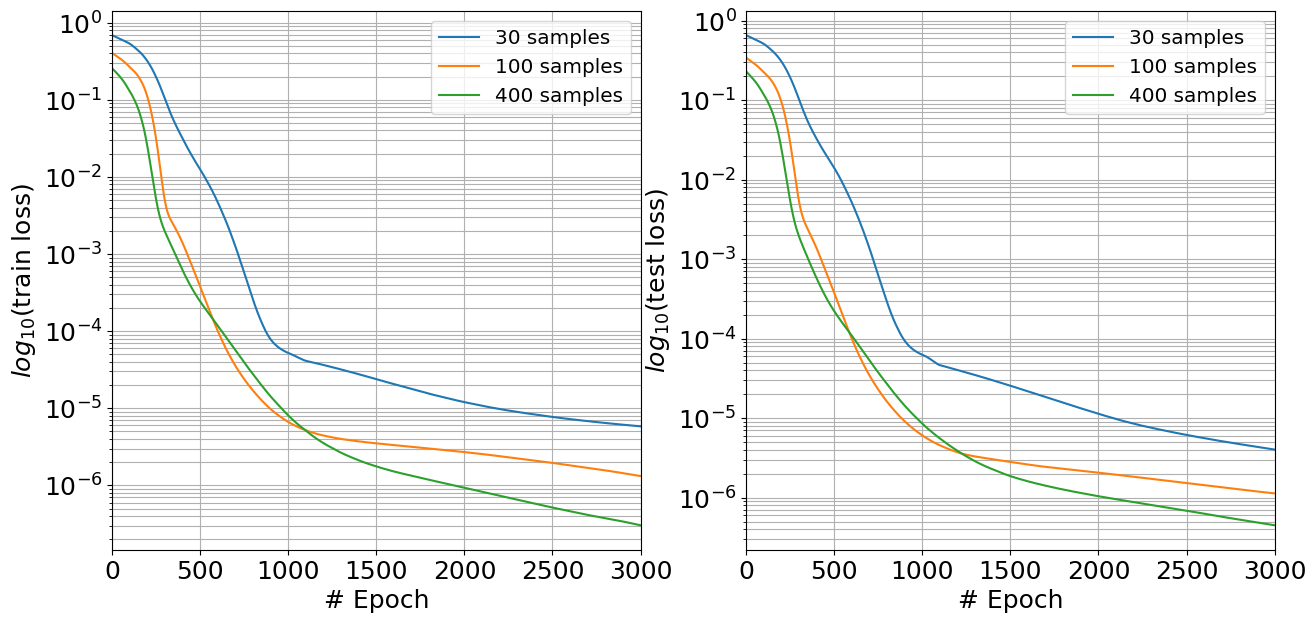

In [114]:
# Cases to plot
num_data_training_rand = np.array([30, 100, 400])

# plot params 
label_size = 18
epoch_lim_axis = 3000
error_lim = 1e-6
## Make a subplot with 2 losses
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

## Training loss
for num_data_training_plot_case in num_data_training_rand:
    index_ndata = np.where(nun_data_training == num_data_training_plot_case)
    label = "{} samples".format(num_data_training_plot_case)     
    ax[0].plot(range(num_epochs), loss_train[index_ndata[0][0],:], label=label)

ax[0].legend(loc='best', prop={'size': .8*label_size})
ax[0].set_xlabel('# Epoch', fontsize = label_size)
ax[0].set_ylabel(r'$log_{10}$(train loss)', fontsize = label_size)
ax[0].set_yscale('log')
ax[0].grid(True, which="both", ls="-")
ax[0].set_xlim(0, epoch_lim_axis)
ax[0].tick_params(axis='both', which='major', labelsize=label_size)

## Training loss
for num_data_training_plot_case in num_data_training_rand:
    index_ndata = np.where(nun_data_training == num_data_training_plot_case)
    label = "{} samples".format(num_data_training_plot_case)     
    ax[1].plot(range(num_epochs), loss_test[index_ndata[0][0],:], label=label)

ax[1].legend(loc='best', prop={'size': .8*label_size})
ax[1].set_xlabel('# Epoch', fontsize = label_size)
ax[1].set_ylabel(r'$log_{10}$(test loss)', fontsize = label_size)
ax[1].set_yscale('log')
ax[1].grid(True, which="both", ls="-")
ax[1].set_xlim(0, epoch_lim_axis)
ax[1].tick_params(axis='both', which='major', labelsize=label_size)
    

path_fig = './../../figures/PINN/loss_vs_epoch.png'
fig.savefig(path_fig, bbox_inches='tight')
plt.show()


## Test error vs number of data training samples

(40, 10)


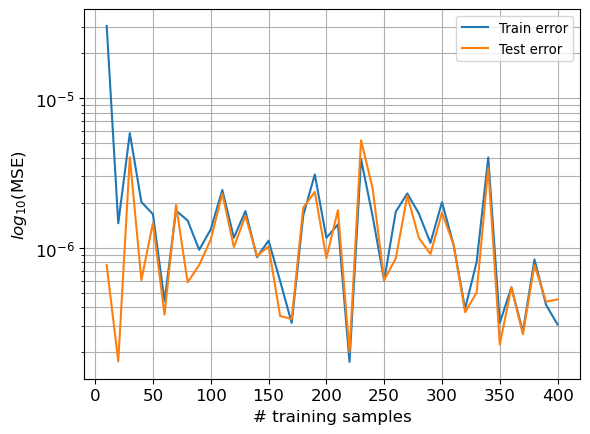

In [135]:
print(loss_train[:,-10:].shape)
label_size = 12
plt.plot(nun_data_training, loss_train[:,-10:].mean(axis = 1), label="Train error")
plt.plot(nun_data_training, loss_test[:,-10:].mean(axis = 1), label="Test error")
plt.legend(loc='best', prop={'size': 12})
plt.xlabel('# training samples', fontsize = label_size)
plt.yscale('log')
plt.ylabel(r'$log_{10}$(MSE)', fontsize = label_size)
plt.grid(True, which="both", ls="-")
plt.legend(loc='best', prop={'size': .8*label_size})
plt.tick_params(axis='both', which='major', labelsize=label_size)


path_fig = './../../figures/PINN/test_train_error.png'
fig.savefig(path_fig, bbox_inches='tight')
plt.show()

## Elapsed time vs num data trainig 

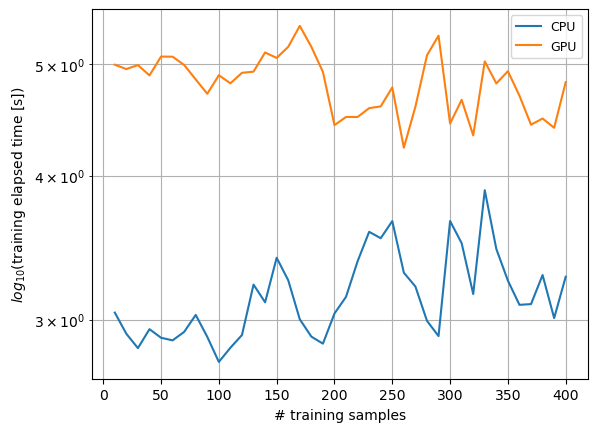

In [119]:
plt.plot(nun_data_training, elapsed_time_cpu, label = 'CPU')
plt.plot(nun_data_training, elapsed_time_gpu, label = 'GPU')
plt.legend(loc='upper right', prop={'size': 6})
plt.yscale('log')
plt.xlabel('# training samples')
plt.legend(loc='best', prop={'size': .5*label_size})
plt.ylabel(r'$log_{10}$(training elapsed time [s])')
plt.grid(True, which="both", ls="-")
path_fig = './../../figures/PINN/exec_time.png'
fig.savefig(path_fig, bbox_inches='tight')



plt.show()

## Train the model for different number of hidden layers 

In [46]:
# range for number of data training
num_hidden_layers_range = range(2,20,4)

# selected device
device = 'cpu'

# bolean to normalize
normalize_bool = True

# boolean to generate gifs
generate_gif = False

# model hyper-params
num_data_training = 400

# result arrays to be filled
loss_test_arch = np.zeros((len(num_hidden_layers_range), num_epochs))
loss_train_arch = np.zeros_like(loss_test_arch)
elapsed_time = np.zeros(len(num_hidden_layers_range))

for i,num_hidden_layers in enumerate(num_hidden_layers_range):
    loss_test_arch[i,:], loss_train_arch[i,:], elapsed_time[i] = train_test_model(
        num_data_training, num_of_neurons, num_of_hidden_layers, num_epochs, lr,
        Theta_train, Y_train, Theta_test, Y_test, min_theta_reduced, max_theta_reduced,
        device, plot_gif_bool, normalization_bool)   

With num_data_training: 400 the final loss is: 5.79540e-07
With num_data_training: 400 the final loss is: 3.86330e-07
With num_data_training: 400 the final loss is: 3.07350e-07
With num_data_training: 400 the final loss is: 8.97504e-07
With num_data_training: 400 the final loss is: 1.55817e-06


## Num of hidden layers vs errors (test, train)

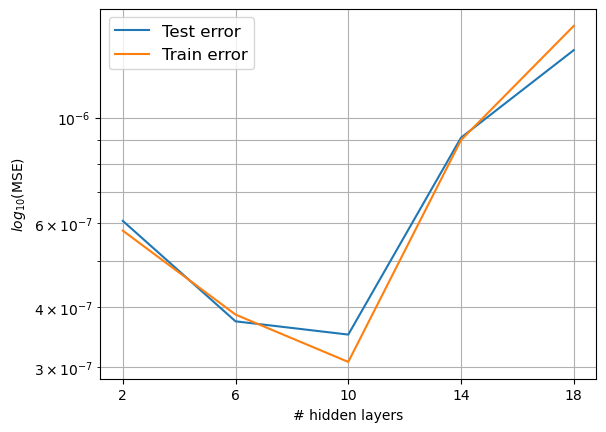

In [47]:
plt.plot(num_hidden_layers_range, loss_test_arch[:,-1], label="Test error")
plt.plot(num_hidden_layers_range, loss_train_arch[:,-1], label="Train error")
plt.xticks(num_hidden_layers_range)  # Set label locations.
plt.legend(loc='best', prop={'size': 12})
plt.xlabel('# hidden layers')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(MSE)')
plt.grid(True, which="both", ls="-")
path_fig = './../../figures/PINN/hiddden_layer_analysis.png'
fig.savefig(path_fig, bbox_inches='tight')

plt.show()